In [1]:
%matplotlib inline

import numpy
import pandas
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
#setting the seed for reproducibility
#seed = 10110
seed = 1206
numpy.random.seed(seed)

#load the dataset
dataframe = pandas.read_csv("F:/UOSEST/Data/Lyle-pparg-ligand/input/pubchem_data/processed/pparg_ligand_data.txt", sep="\t")

In [3]:
mols = []
fps = []

#get molecules and then get fingerprints from those
for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    mols.append(mol)
    fps.append(fp)

#Convert the RDKit vectors into numpy arrays
#Based on: http://www.rdkit.org/docs/Cookbook.html#using-scikit-learn-with-rdkit
np_fps = []
for fp in fps:
    arr = numpy.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

np_fps_array = numpy.array(np_fps)
#Need to encode my classes
#Ligand = 0, not_ligand = 1
encoder = LabelEncoder()
encoder.fit(dataframe['Type'])
enc_y = encoder.transform(dataframe['Type'])

In [4]:
#Create the machine learning model
from keras import optimizers
def create_deep_learning_model():
    model = Sequential()
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
tmp = [[x,y] for x, y in zip(np_fps_array, enc_y)]
tmp = shuffle(tmp)
X = [n[0] for n in tmp]
Y = [n[1] for n in tmp]
X = np.array(X)
Y= np.array(Y)

In [6]:
n = len(X)
p = 0.8
X_test = X[int(n*p):]
Y_test = Y[int(n*p):]

X_train = X[:int(n*p)]
Y_train = Y[:int(n*p)]

In [7]:
sm = SMOTE(random_state=12, ratio = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

1    608
0    608
dtype: int64

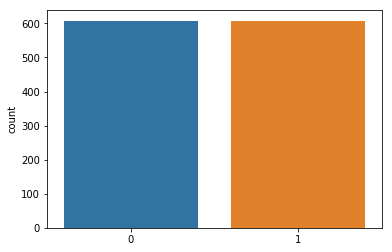

In [21]:
import seaborn as sns
sns.countplot(y_train_res)
pd.Series(y_train_res).value_counts()

1    154
0      6
dtype: int64

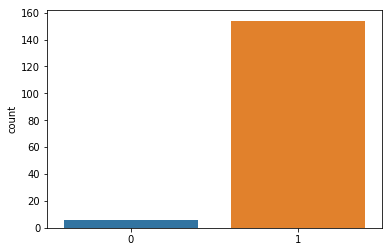

In [22]:
import seaborn as sns
sns.countplot(Y_test)
pd.Series(Y_test).value_counts()

In [8]:
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=5, batch_size=5)
estimator.fit(x_train_res, y_train_res)


Epoch 1/5
1216/1216 [==============================] - 3s 3ms/step - loss: 0.0976 - acc: 0.9630
Epoch 2/5
1216/1216 [==============================] - 1s 1ms/step - loss: 0.0227 - acc: 0.9942
Epoch 3/5
1216/1216 [==============================] - 1s 1ms/step - loss: 3.1617e-05 - acc: 1.0000
Epoch 4/5
1216/1216 [==============================] - 1s 1ms/step - loss: 7.9554e-06 - acc: 1.0000A: 1s - loss: 4.9187e-06 - acc: 1.00 - ETA: 1s - loss: 
Epoch 5/5
1216/1216 [==============================] - 1s 1ms/step - loss: 4.3487e-06 - acc: 1.0000


NameError: name 'X_train_res' is not defined

In [11]:
Y_pred = estimator.predict(X_test)
conf_mat = confusion_matrix(Y_test, Y_pred)

In [12]:
conf_mat

array([[  0,   6],
       [  2, 152]], dtype=int64)

In [16]:
recall = conf_mat[0][0]/sum(conf_mat[0])
specificity = conf_mat[1][1] / sum(conf_mat[1])
print("recall = " + str(recall))
print("specificity = " + str(specificity))

recall = 0.0
specificity = 0.987012987012987


In [14]:
recall

0.0

In [23]:
152/160

0.95